# Use of EXIOBASE3.8
We will illustrate here the use of EXIOBASE by calculating EU GHG emissions from different perspectives.

Some of these results are used in the "Luxembourg in Transition" report.

Note: there is a bit of experimentation going on, for example the regionalization of the stressor matrix.

<thomas.gibon@list.lu>

Credit <maxime.agez@polymtl.ca> for the stressor extensions and characterization data (not used for EXIOBASE>3.8.2).

Characterized impacts come with EXIOBASE after version 3.8.2, so check your version.

In [1]:
# Let's get comfortable first
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

C:\Users\Gibon\AppData\Local\Temp\ipykernel_59856\1931309167.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Import the necessary modules.

In [2]:
import pymrio as mr
import pandas as pd
import numpy as np
from scipy.linalg import block_diag
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline
import SPA
from matplotlib.patches import Rectangle

Import the data. You'll need to have downloaded EXIOBASE 3.8 files from https://zenodo.org/record/4277368 into `EXIOBASE_PATH`.
I recommend using the command described below.
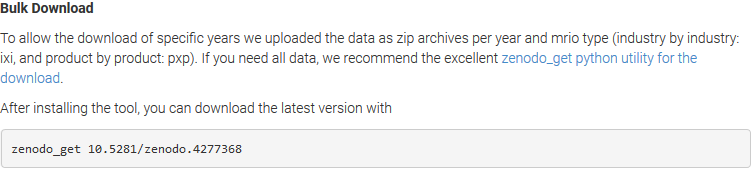

Then specify a year you want to work with. Note: in the 3.8 version, year 2019 has some issues, specifically for EU and Denmark in particular. You may want to choose another year instead.

The original characterization matrix is from https://zenodo.org/record/3955079/

...and you can find the stressors extension and characterization data at https://figshare.com/articles/dataset/Additional_environmental_extensions_for_EXIOBASE3_based_on_USEEEIO/12471278/1

NOTE: the latest version of `pymrio` includes an automatic download function.

NOTE2: EXIOBASE>3.8.2 comes with characterized impacts, so there's nothing to do regarding the importation of characterization factors.

In [3]:
year = 2019
EXIOBASE_PATH = '../EXIOBASE/'
# EXIOBASE_PATH = '../exiobase/'

Download the latest version (comment out if unnecessary)

In [4]:
exio_meta = mr.download_exiobase3(
    storage_folder=EXIOBASE_PATH,
    system="pxp",
    years=[2018, 2019, 2020],
    doi="10.5281/zenodo.4588235"
)

Then, just import the IO system with `pymrio`:

In [5]:
io = mr.parse_exiobase3(path=EXIOBASE_PATH+'IOT_{}_pxp.zip'.format(year))

Import the population data.

In [6]:
population = pd.read_csv(EXIOBASE_PATH+'exiobase_population.txt',sep='\t',index_col=0)
io.population=pd.DataFrame(columns=['population'], data=population.loc[year].values, index=population.columns).T

In [7]:
io.calc_all()

Import additional stressors. Not necessary since version 3.8.2.

In [8]:
# Credit to Maxime Agez for the stressor extension
stressors=pd.read_csv(EXIOBASE_PATH+'Expanded_S.csv',
                     index_col=[0],
                     header=[0,1])

In [9]:
stressors.shape

(1766, 9800)

In [10]:
# stressors.columns=io.A.columns
# short_S=io.satellite.S
# short_S.shape

In [11]:
# io.satellite.S=pd.concat([short_S,stressors],axis=0)

In [12]:
# io.satellite.F=io.satellite.S.mul(io.x['indout'])

In [13]:
# F_Y_padding=pd.DataFrame(np.zeros([stressors.shape[0],io.satellite.F_Y.shape[1]]),
#                         index=stressors.index,
#                         columns=io.satellite.F_Y.columns)

In [14]:
# io.satellite.F_Y=io.satellite.F_Y.append(F_Y_padding)

Run the various calculations (satellite factors, footprint reports, ...)

Import characterization.

In [15]:
# Q_base=pd.read_csv(EXIOBASE_PATH+'C_exio_IW.csv',
#              index_col=[0])
# padding=short_S.shape[0]-Q_base.shape[1]
# Q_energy=pd.DataFrame(np.zeros([Q_base.shape[0],padding]),
#                      index=Q_base.index,
#                      columns=short_S.index[-padding:])
# Q_ext=pd.read_csv(EXIOBASE_PATH+'C_expansion_IW.csv',
#              index_col=[0])

In [16]:
# Q_base.shape

In [17]:
# Q=pd.concat([Q_base,Q_energy,Q_ext],axis=1)
# Q.shape

In [18]:
# impact = dict()

In [19]:
# impact['S'] = Q.dot(io.satellite.S) # unit stressors, per M€ 
# impact['F'] = Q.dot(io.satellite.F) # total stressors
# impact['F_Y'] = Q.dot(io.satellite.F_Y) # same for households
# impact['name'] = 'impact' # and name
# io.impact = mr.Extension(**impact) # finally, add it as a proper extension

In [20]:
# io.calc_all()

In [52]:
ind = 'Climate change midpoint | ILCD recommended CF | Global warming potential 100 years',

# Test: Calculate the share of specific sectors over national footprint

### Focus on electronics

In [24]:
sects = ['Office machinery and computers (30)',
'Electrical machinery and apparatus n.e.c. (31)',
        'Radio, television and communication equipment and apparatus (32)',
        'Medical, precision and optical instruments, watches and clocks (33)']

In [25]:
list(io.impacts.get_index())

['Value Added',
 'Employment',
 'Employment hour',
 'GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)',
 'Human toxicity (USEtox) | USEtox2008 | CTUh (Rosenbaum et al., 2008)',
 'Fresh water Ecotoxicity (USEtox) | USEtox2008 | CTUe (Rosenbaum et al., 2008)',
 'EPS | Damage Approach | EPS (Steen, 1999))',
 'Carcinogenic effects on humans (H.A) | ECOINDICATOR 99 (H.A) | Carcinogenic effects on humans (H.A)',
 'Respiratory effects on humans caused by organic substances (H.A) | ECOINDICATOR 99 (H.A) | Respiratory effects on humans caused by organic substances (H.A)',
 'Respiratory effects on humans caused by inorganic substances (H.A) | ECOINDICATOR 99 (H.A) | Respiratory effects on humans caused by inorganic substances (H.A)',
 'Damages to human health caused by climate change (H.A) | ECOINDICATOR 99 (H.A) | Damages to human health caused by climate change (H.A)',
 'Damage to Ecosystem Quality caused by ecotoxic emissions (H.A) | ECOINDICATOR 

In [26]:
results = {}
abso_el = []

for sect in sects:
    results[sect] = io.impacts.D_cba.xs(sect, level=1, axis=1).loc[ind]/io.impacts.D_cba_reg.loc[ind]
    results[sect].loc['EU'] = io.impacts.D_cba.xs(sect, level=1, axis=1).loc[ind][:28].sum()/io.impacts.D_cba_reg.loc[ind][:28].sum()
    abso_el.append(io.impacts.D_cba.xs(sect, level=1, axis=1).loc[ind][:28].sum())

In [27]:
sum(abso_el)

151776175265.79602

In [28]:
io.impacts.D_cba_reg.loc[ind][:28].sum()

4621828881748.26

In [29]:
electronics = pd.concat(results.values(), keys=results.keys(), axis=1)
electronics['TOTAL'] = electronics.sum(1)
electronics.to_excel('output/electronics_footprint.xlsx')

OK continue

In [30]:
pd.concat([
    io.impacts.D_cba_reg.loc[ind],
    io.impacts.D_pba_reg.loc[ind],
    io.impacts.D_imp_reg.loc[ind],
    io.impacts.D_exp_reg.loc[ind],
#     FD.loc[:,FD.sum(0)!=0]
    ],
  axis=1
 ).loc[['BE','DE','FR','LU']]

,Climate change midpoint | ILCD recommended CF | Global warming potential 100 years,Climate change midpoint | ILCD recommended CF | Global warming potential 100 years,Climate change midpoint | ILCD recommended CF | Global warming potential 100 years,Climate change midpoint | ILCD recommended CF | Global warming potential 100 years
BE,1.393453e+11,8.517078e+10,1.068956e+11,5.272104e+10
DE,9.099706e+11,7.147311e+11,4.476686e+11,2.524291e+11
FR,5.251869e+11,3.413480e+11,3.069405e+11,1.231017e+11
LU,1.632092e+10,9.095837e+09,1.496724e+10,7.742156e+09


In [31]:
io.population[['BE','DE','FR','LU']]

,BE,DE,FR,LU
population,11539000,83517000,65130000,616000


### Focus on research sector

This is just an estimate of the impact of the research sector in Luxembourg, for carbon footprinting purposes.

In [32]:
pd.set_option('display.max_rows', 200)
research_employees_LU=io.satellite.D_pba['LU','Research and development services (73)'].iloc[9:15].sum()*1000

In [33]:
#https://statistiques.public.lu/stat/TableViewer/tableView.aspx?ReportId=13555&IF_Language=eng&MainTheme=4&FldrName=9&RFPath=2222
research_employees_LU=5468

In [34]:
io.impacts.D_cba.loc[ind,('LU','Research and development services (73)')]

impact
Climate change midpoint | ILCD recommended CF | Global warming potential 100 years    4.473823e+07
Name: (LU, Research and development services (73)), dtype: float64

In [35]:
pd.set_option('display.max_rows', 200)
io.impacts.D_cba.loc[ind,('LU','Research and development services (73)')]/research_employees_LU

impact
Climate change midpoint | ILCD recommended CF | Global warming potential 100 years    8181.826512
Name: (LU, Research and development services (73)), dtype: float64

In [36]:
io.impacts.D_pba.loc[ind,('LU','Research and development services (73)')]/research_employees_LU

impact
Climate change midpoint | ILCD recommended CF | Global warming potential 100 years    420.476079
Name: (LU, Research and development services (73)), dtype: float64

In [37]:
io.impacts.D_cba.loc[ind,'LU'].sum()/440000

sector
Paddy rice                                                                                                                                 3.214213e+01
Wheat                                                                                                                                      2.383724e+02
Cereal grains nec                                                                                                                          6.172601e+01
Vegetables, fruit, nuts                                                                                                                    8.657159e+02
Oil seeds                                                                                                                                  2.227210e+02
Sugar cane, sugar beet                                                                                                                     4.963611e-05
Plant-based fibers                                                               

## Making own indicators

Here we're trying to replicate the UNFCCC accounting, with actual GWP factors used for the various greenhouse gases. This will most likely be an underestimate of actual GHG emissions, which should be calculated with the proper characterization method imported earlier. For comparison purposes only.

In [22]:
GWP100_unfccc=pd.Series(
[1,1,1,
34,34,34,34,34,34,34,34,34,34,
265,265]
    ,
index=
['CO2 - combustion - air',
 'CO2 - non combustion - Cement production - air',
 'CO2 - non combustion - Lime production - air',
 'CH4 - combustion - air',
 'CH4 - non combustion - Extraction/production of (natural) gas - air',
 'CH4 - non combustion - Extraction/production of crude oil - air',
 'CH4 - non combustion - Mining of antracite - air',
 'CH4 - non combustion - Mining of bituminous coal - air',
 'CH4 - non combustion - Mining of coking coal - air',
 'CH4 - non combustion - Mining of lignite (brown coal) - air',
 'CH4 - non combustion - Mining of sub-bituminous coal - air',
 'CH4 - non combustion - Oil refinery - air',
 'CH4 - agriculture - air',
 'N2O - combustion - air',
 'N2O - agriculture - air']
)

Now we prepare the data for plotting.

## Bar chart of per-capita EU GHG emissions

In [23]:
method = GWP100_unfccc # hand-made method, in case you set up other method vectors

# Total consumption- and production-based
GHG_cba_tot = method.dot(io.satellite.D_cba_reg.loc[method.index])
GHG_pba_tot = method.dot(io.satellite.D_pba_reg.loc[method.index])

# Per-capita consumption- and production-based
GHG_cba_cap = method.dot(io.satellite.D_cba_cap.loc[method.index])
GHG_pba_cap = method.dot(io.satellite.D_pba_cap.loc[method.index])

# Total import and export
GHG_imp_tot = method.dot(io.satellite.D_imp_reg.loc[method.index])
GHG_exp_tot = method.dot(io.satellite.D_exp_reg.loc[method.index])

# Per-capita import and export
GHG_imp_cap = method.dot(io.satellite.D_imp_cap.loc[method.index])
GHG_exp_cap = method.dot(io.satellite.D_exp_cap.loc[method.index])

# And direct emissions from households, NGOs and governments
GHG_direct=method.dot(io.satellite.F_Y.loc[method.index]).groupby('region').sum()

In [24]:
io.impacts.F_Y

In [25]:
io.impacts

In [26]:
io.impacts.D_cba.groupby('region', axis=1).sum().loc[ind]['DE']

909970590305.7131

In [27]:
io.impacts.D_cba.groupby('region', axis=1).sum().loc[ind,'DE']/population.loc[2019,'DE']

10895.633108297869

In [28]:
io.impacts.D_cba_cap.loc[ind,'DE']

10895.63310828933

In [29]:
io.satellite.D_cba.groupby('region', axis=1).sum()['DE']

stressor
Taxes less subsidies on products purchased: Total                                                1.605099e+05
Other net taxes on production                                                                    2.195219e+04
Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled       8.253540e+04
Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled    6.919040e+05
Compensation of employees; wages, salaries, & employers' social contributions: High-skilled      8.995345e+05
                                                                                                     ...     
Energy Carrier Net TMAR                                                                          7.638064e+05
Energy Carrier Net TOTH                                                                          1.129378e+05
Energy Carrier Net TRAI                                                                          6.443260e+04
E

In [19]:
io.satellite.D_cba.groupby('region', axis=1).sum().loc['CO2 - combustion - air','DE']/population.loc[2019,'DE']

8238.573866861601

In [20]:
io.satellite.D_cba_cap.loc['CO2 - combustion - air','DE']

8238.573866865428

In [21]:
io.satellite.F_Y.loc['CO2 - combustion - air','DE']/population.loc[2019,'DE']

category
Final consumption expenditure by households                                             1717.185632
Final consumption expenditure by non-profit organisations serving households (NPISH)      82.550989
Final consumption expenditure by government                                              144.609956
Gross fixed capital formation                                                              0.000000
Changes in inventories                                                                     0.000000
Changes in valuables                                                                       0.000000
Exports: Total (fob)                                                                       0.000000
Name: CO2 - combustion - air, dtype: float64

In [22]:
io.impacts?

In [23]:
io.satellite.F_Y.groupby(level="region", axis=1, sort=False).sum().loc['CO2 - combustion - air','DE']

162385993103.76

In [25]:
(GHG_cba_cap + GHG_direct/population.loc[2019])[['FR','DE','BE','LU']]

FR     9389.137006
DE    12905.398804
BE    14828.668307
LU    29925.836251
dtype: float64

In [50]:
ind[0]

'Climate change midpoint | ILCD recommended CF | Global warming potential 100 years'

In [26]:
D_cba_cap_FR = (io.impacts.D_cba.loc[ind,'FR']/population.loc[year,'FR']).T[ind[0]].sort_values(ascending=False)
D_cba_cap_BE = (io.impacts.D_cba.loc[ind,'BE']/population.loc[year,'BE']).T[ind[0]].sort_values(ascending=False)
D_cba_cap_DE = (io.impacts.D_cba.loc[ind,'DE']/population.loc[year,'DE']).T[ind[0]].sort_values(ascending=False)

In [27]:
pd.concat([D_cba_cap_FR,D_cba_cap_BE,D_cba_cap_DE], keys=['FR','BE','DE'],axis=1).to_csv('comp_FRBEDE.csv')

In [35]:
footprints_EU_all_GHGs=pd.concat([io.impacts.D_pba_reg.loc[ind],
                         io.impacts.D_imp_reg.loc[ind],
                         io.impacts.D_exp_reg.loc[ind],
                         io.impacts.D_cba_reg.loc[ind],
#                          io.impacts.F_Y.loc[ind].groupby('region').sum() # This is a bit problematic, F_Y doesn't seem to get calculated...
                         GHG_direct],
                            axis=1,keys=('Production',
                                         'Imports',
                                         'Exports',
                                         'Consumption',
                                        'Direct emissions'))

In [36]:
footprints_EU_all_GHGs

,Production,Imports,Exports,Consumption,Direct emissions
AT,6.286413e+10,5.267684e+10,2.313695e+10,9.240401e+10,1.592151e+10
BE,8.517078e+10,1.068956e+11,5.272104e+10,1.393453e+11,2.801944e+10
BG,4.724815e+10,2.172999e+10,2.873728e+10,4.024085e+10,4.915474e+09
CY,1.371396e+10,6.345254e+09,1.026194e+10,9.797267e+09,1.617370e+09
CZ,1.115427e+11,4.626323e+10,3.832408e+10,1.194819e+11,1.246973e+10
DE,7.147311e+11,4.476686e+11,2.524291e+11,9.099706e+11,1.659129e+11
DK,5.591273e+10,4.591618e+10,3.028566e+10,7.154325e+10,8.919634e+09
EE,1.802544e+10,7.594924e+09,8.722491e+09,1.689787e+10,8.940027e+08
ES,2.672023e+11,1.535794e+11,1.068725e+11,3.139093e+11,6.512461e+10
FI,5.600454e+10,3.247042e+10,2.140121e+10,6.707375e+10,5.108049e+09


In [37]:
footprints_EU_UNFCCC=pd.concat([GHG_pba_tot,
                         GHG_imp_tot,
                         GHG_exp_tot,
                         GHG_cba_tot,
                         GHG_direct],
                            axis=1,keys=('Production',
                                         'Imports',
                                         'Exports',
                                         'Consumption',
                                        'Direct emissions')).iloc[:28,:].sort_values(by='Production',ascending=False)/1000000000

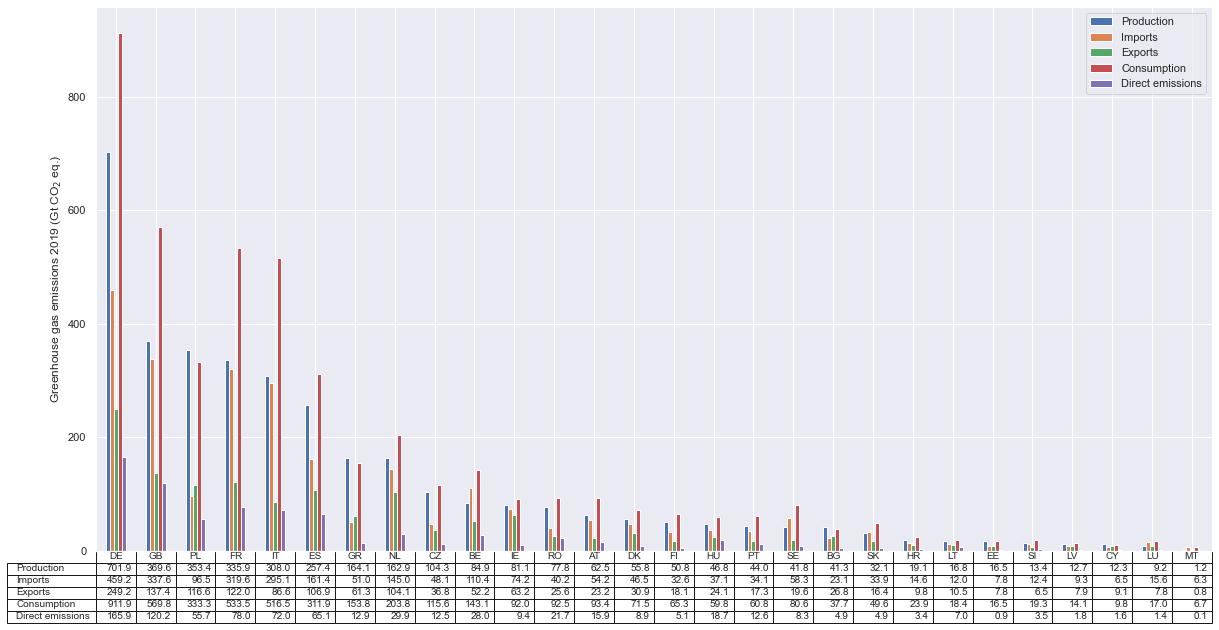

In [38]:
sns.set(font_scale=1)

fig,ax=plt.subplots(figsize=(20,10))
footprints_EU_UNFCCC.plot(kind='bar',ax=ax)
ax.set_ylabel(f'Greenhouse gas emissions {year} (Gt CO$_{2}$ eq.)')
ax.set_xticklabels([])
table = plt.table(colLabels=footprints_EU_UNFCCC.index,
          rowLabels=footprints_EU_UNFCCC.columns,
          cellText=footprints_EU_UNFCCC.T.round(1).values,loc='bottom')

table.set_fontsize(10)

In [39]:
footprints_EU_UNFCCC.loc['LU']

Production           9.195362
Imports             15.611148
Exports              7.806775
Consumption         16.999735
Direct emissions     1.434580
Name: LU, dtype: float64

In [40]:
footprints_EU_cap=pd.concat([GHG_pba_cap,
#                              GHG_imp_cap,
#                              GHG_exp_cap,
                             GHG_cba_cap,
                             GHG_direct.div(population.loc[year])],
                            axis=1,keys=('Production',
#                                          'Imports',
#                                          'Exports',
                                         'Consumption',
                                        'Direct emissions')).iloc[:28,:].sort_values(by='Production',ascending=False)/1000

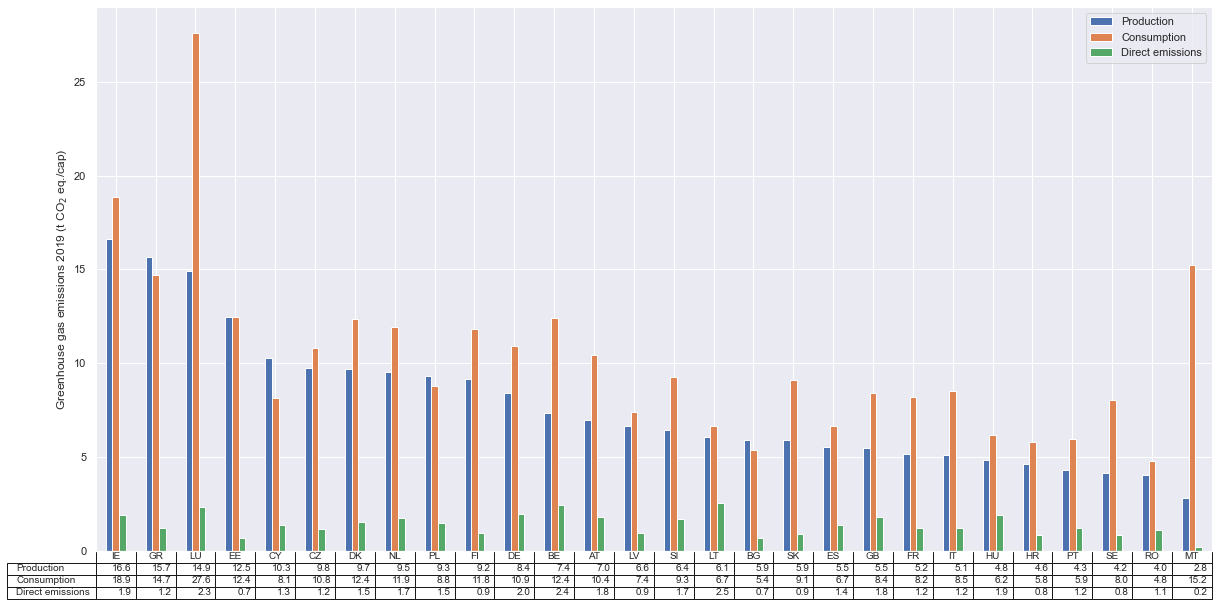

In [41]:
sns.set(font_scale=1)

fig,ax=plt.subplots(figsize=(20,10))
footprints_EU_cap.plot(kind='bar',ax=ax)
ax.set_ylabel(f'Greenhouse gas emissions {year} (t CO$_{2}$ eq./cap)')
ax.set_xticklabels([])
table = plt.table(colLabels=footprints_EU_cap.index,
          rowLabels=footprints_EU_cap.columns,
          cellText=footprints_EU_cap.T.round(1).values,loc='bottom')

table.set_fontsize(10)

In [ ]:
footprints_EU_tot=pd.concat([GHG_pba_tot,
#                              GHG_imp_cap,
#                              GHG_exp_cap,
                             GHG_cba_tot,
                             GHG_direct],
                            axis=1,keys=('Production',
#                                          'Imports',
#                                          'Exports',
                                         'Consumption',
                                        'Direct emissions')).iloc[:28,:].sort_values(by='Production',ascending=False)*1e-9
footprints_EU_tot.to_csv('output/footprint_EU_{}.csv'.format(year))

## Focus on Luxembourg
### Carbon footprint
I think $GHG_{cons pro LU}=\widehat{S_{GWP100}}L\widehat{y_{LU}}$ should work?

In [42]:
Y_LU = io.Y['LU'].sum(1)

In [47]:
GHG_cons_pro_LU=io.L.multiply(io.impacts.S.loc[ind],axis=0).multiply(Y_LU)

In [48]:
GHG_cons_pro_LU.index=GHG_cons_pro_LU.columns

In [49]:
GHG_cons_pro_LU.loc[:,('TOTAL','TOTAL')] = GHG_cons_pro_LU.sum(1)
GHG_cons_pro_LU.loc[('TOTAL','TOTAL'),:] = GHG_cons_pro_LU.sum(0)

C:\Users\Gibon\AppData\Local\Temp\ipykernel_49676\168151993.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  GHG_cons_pro_LU_simplified=GHG_cons_pro_LU.sum(level='sector') \
C:\Users\Gibon\AppData\Local\Temp\ipykernel_49676\168151993.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  GHG_cons_pro_LU_simplified=GHG_cons_pro_LU.sum(level='sector') \


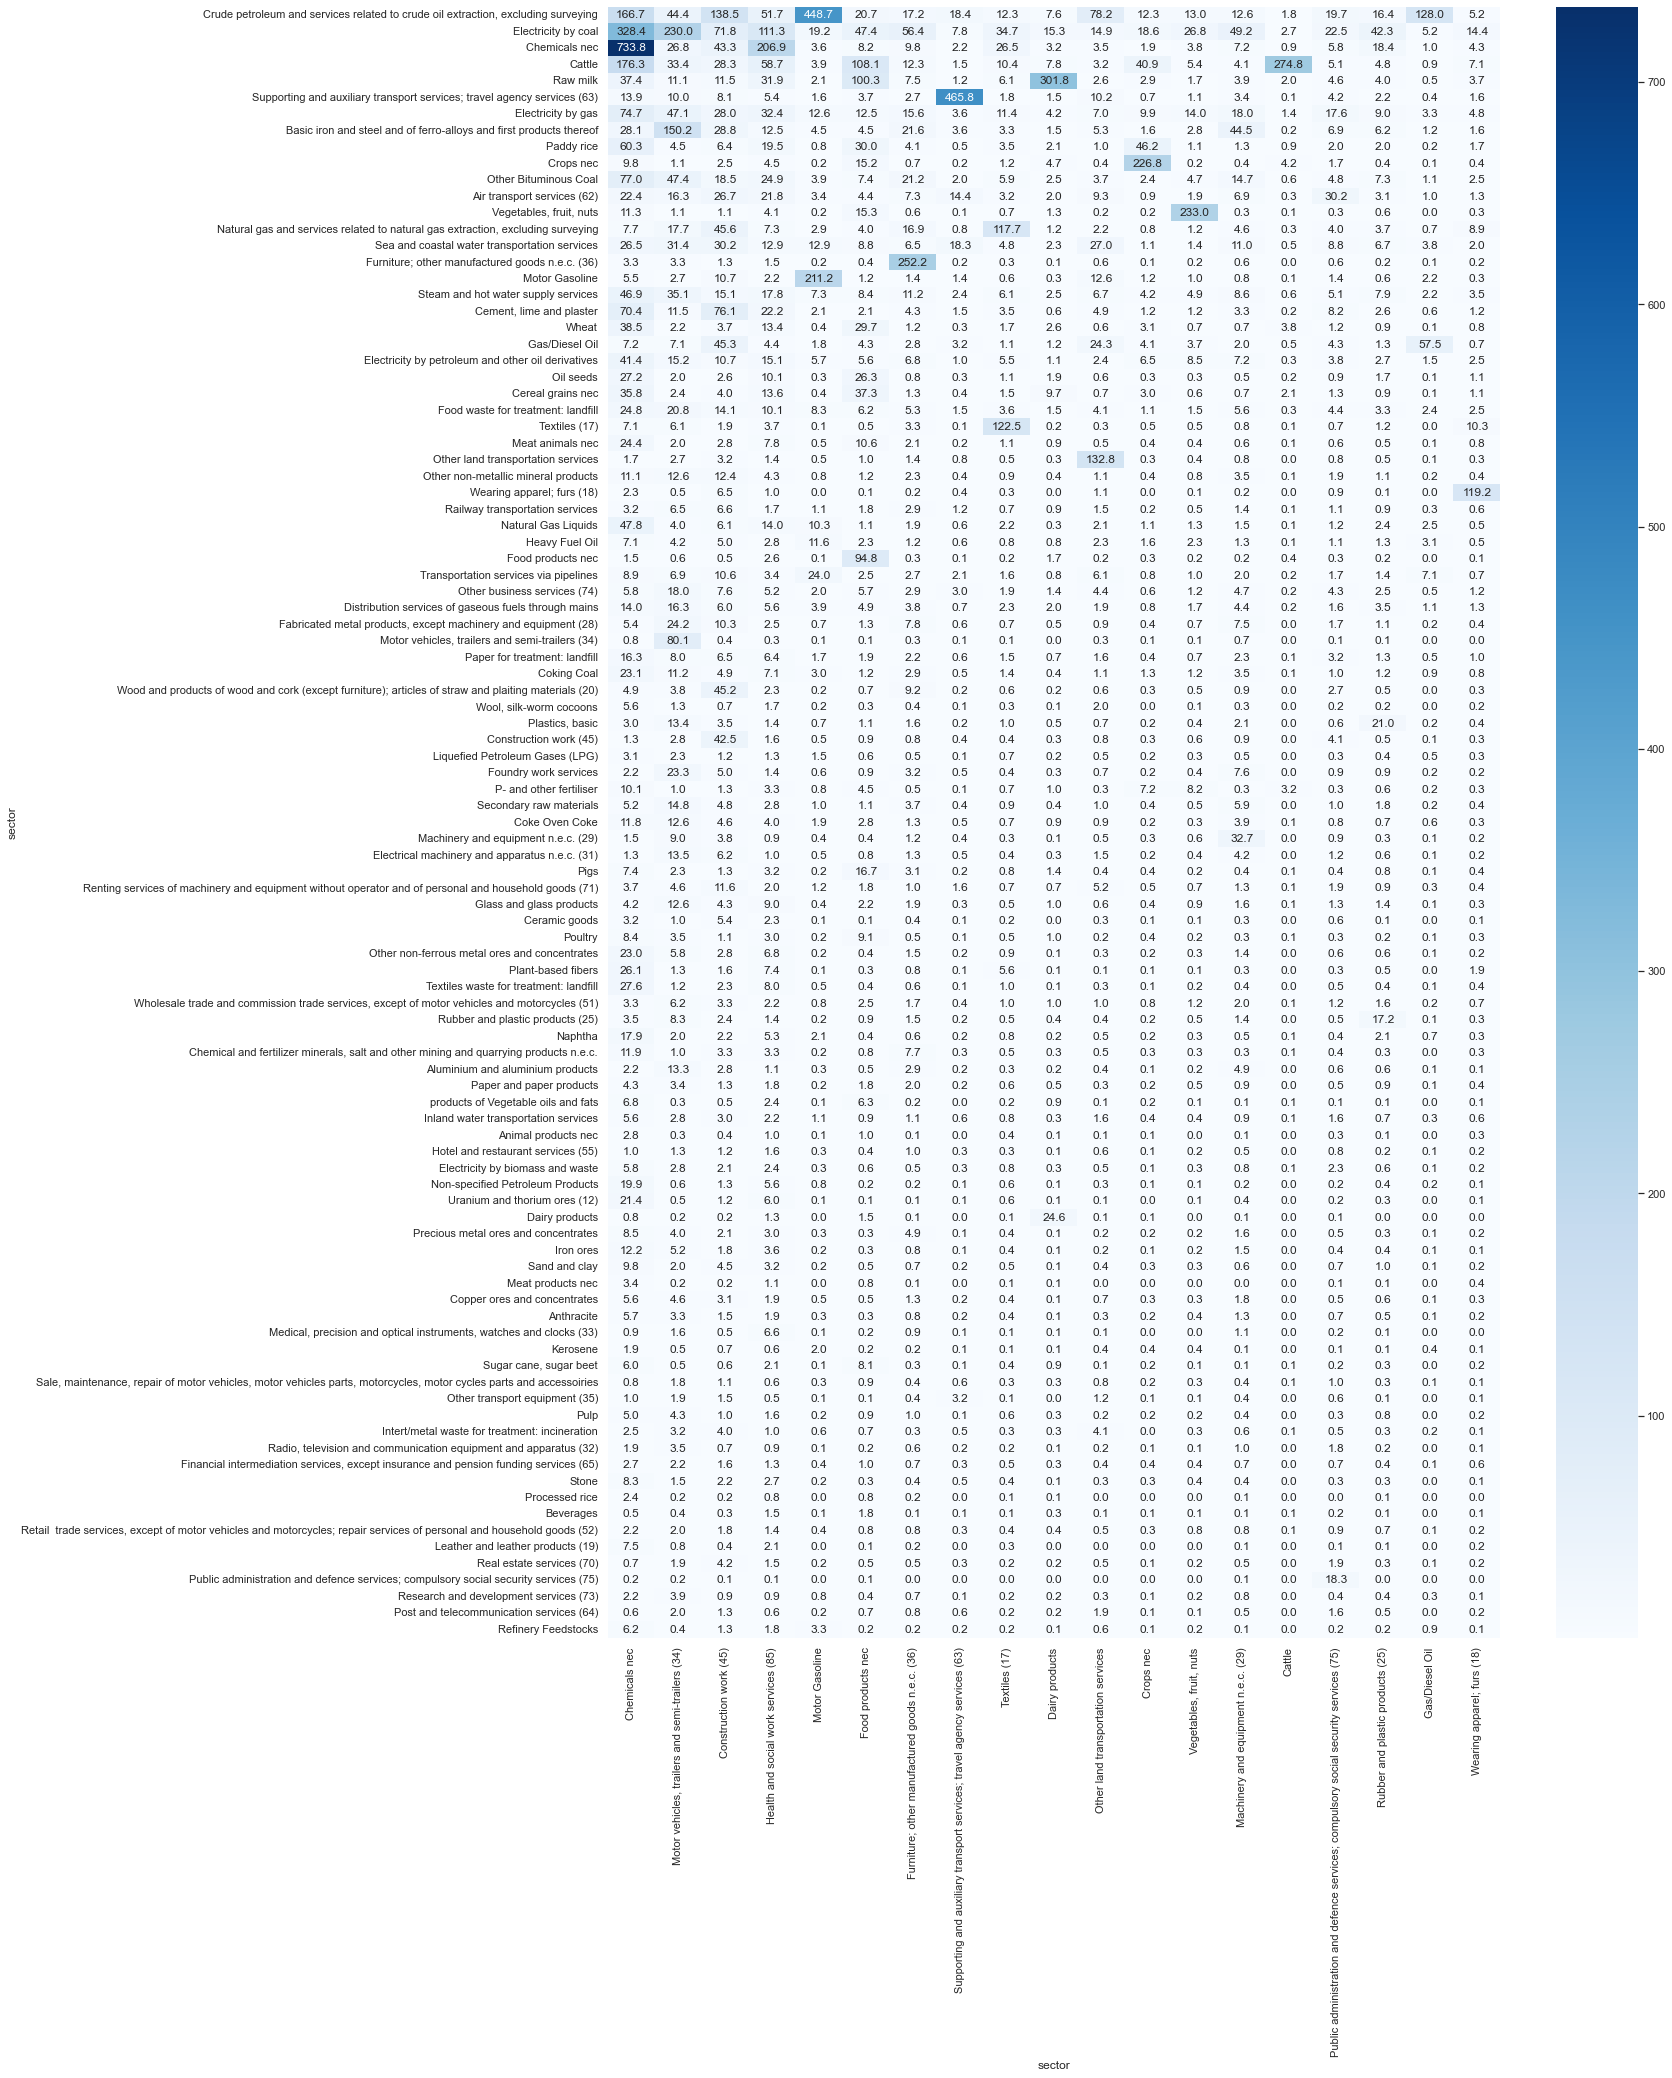

In [50]:
GHG_cons_pro_LU_simplified=GHG_cons_pro_LU.sum(level='sector') \
    .sum(level='sector',axis=1) \
    .sort_values(ascending=False, by='TOTAL') \
    .sort_values(ascending=False, by='TOTAL',axis=1).iloc[:100,:20].drop('TOTAL').drop('TOTAL',axis=1)*1e-6

fig, ax = plt.subplots(figsize=(20,30))
sns.heatmap(GHG_cons_pro_LU_simplified,
            annot=True,
#             norm=matplotlib.colors.LogNorm(vmin=1e-6,
#                                            vmax=GHG_snap.max().max()),
            cmap='Blues',
            fmt='.1f')

In [51]:
io.impacts.D_pba.loc[ind,'LU'].to_csv('output/LU_pba.csv')

In [42]:
type(io.satellite.F_Y)

pandas.core.frame.DataFrame

In [45]:
io.impacts.F_Y = io.impacts.F_hh.copy()

In [ ]:
GHG_snap = GHG_cons_pro_LU.sort_values(('TOTAL','TOTAL'),axis=1,ascending=False).sort_values(('TOTAL','TOTAL'),ascending=False).iloc[:100,:20].drop('TOTAL').drop('TOTAL',axis=1)*1e-6
fig, ax = plt.subplots(figsize=(20,30))
sns.heatmap(GHG_snap, annot=True,
#             norm=matplotlib.colors.LogNorm(vmin=1e-6,
#                                            vmax=GHG_snap.max().max()),
            cmap='Blues',
           fmt='.1f')

In [ ]:
io.impacts.F.loc[ind]

In [ ]:
io.satellite.F

In [ ]:
CFs = np.linalg.lstsq(a=io.satellite.F.T,
                b=io.impacts.F)

In [ ]:
CFs_GWP100_df = pd.DataFrame(index=io.satellite.get_index().tolist(),
                             columns=[ind],
                             data=CFs_GWP100[0])

In [ ]:
CFs_GWP100_df

In [ ]:
io.impacts.F_Y = CFs_GWP100_df.dot(io.satellite.F_Y)

In [ ]:
# We can do a quick structural path analysis

region='LU'
scale=1e-9 # in Mtons

paths = SPA.SPA(io.impacts.S.loc[ind]*scale,
            io.A,
            io.Y[region].sum(1),
            Tmax=30,
            threshold=.0001,
            filename=f'output/test_{region}_{ind}_{year}.csv',
            M=io.impacts.M.loc[ind]*scale,
            direct=io.impacts.F_Y[region].sum(1)[ind]*scale)

In [ ]:
paths

### Carbon flows

We make a map of carbon flows, and then try to aggregate that to match the region classification we use.

In [ ]:
# Get the GHG emissions embodied in final demand: diag(S)*L*diag(y)
GHG_cons_pro=io.L.multiply(io.impact.S.loc[ind],axis=0).dot(io.Y.sum(level='region',axis=1)).sum(level='region',axis=0)
# GHG_cons_pro['TOTAL'] = GHG_cons_pro.sum(1)
# GHG_cons_pro.loc['TOTAL'] = GHG_cons_pro.sum(0)

In [ ]:
GHG_cons_pro_FD=pd.DataFrame(np.diag(io.impact.F_Y.sum(level='region',axis=1).loc[ind]),index=GHG_cons_pro.index,columns=GHG_cons_pro.columns)
GHG_cons_pro_tot=GHG_cons_pro+GHG_cons_pro_FD

## Two-region aggregation

In [ ]:
# 2-reg agg
reg_agg_matrix = np.zeros([49,2])

reg_agg_matrix[io.get_regions()=='LU',0] = 1
reg_agg_matrix[:,1] = 1-reg_agg_matrix.sum(1)

reg_agg_matrix=reg_agg_matrix.T # argh, the matrix was transposed

assert all(reg_agg_matrix.sum(0)==1)

In [ ]:
reg_agg_matrix

In [ ]:
# Reaggregate
reg_agg_names=['LU','Rest of the world']
io2 = io.aggregate(region_agg=reg_agg_matrix,
                     region_names=reg_agg_names,
                        inplace=False)

In [ ]:
# Calculate the new system
io2.calc_all()

In [ ]:
Y_LU=io2.Y['LU'].sum(1)
GHG_cons_pro_LU=io2.L.multiply(io2.impact.S.loc[ind],axis=0).multiply(Y_LU)*1e-9

In [ ]:
GHG_cons_pro_LU

In [ ]:
GHG_direct_LU=io2.Z.multiply(io2.impact.S.loc[ind],axis=0)*1e-9

In [ ]:
GHG_direct_LU.sum(level='region').sum(level='region',axis=1)

### Aggregate and disaggregate for the functional area, Luxembourg excluded (population-wise, i.e. only consumption-based would make sense)
We need a 49 to 4 matrix, to reaggregate for Luxembourg, functional area, EU28, and rest of the world.
Aggregating the regions will lose the multiplier details and generate discrepancies between aggregated and non-aggregated footprints. To remediate this, we will also aggregate the carbon flow map calculated above.

In [ ]:
reg_agg_matrix = np.zeros([49,7])

# We'll disaggregate the various countries to compose the functional area
# Flows will follow population, for a lack of a better proxy for emissions
# This is probably wrong for territorial emissions, but should hold for consumption

population_FA=pd.Series({'BE':225772,
                         'DE':378881,
                         'FR':781852},
                          name='population')

FA_shares=population_FA/io.population
FA_shares.fillna(inplace=True, value=0)
FA_shares=FA_shares.reindex_like(io.population)

reg_agg_matrix[io.get_regions()=='LU',0] = 1
reg_agg_matrix[:,1] = FA_shares
reg_agg_matrix[io.get_regions()=='BE',2] = 1-reg_agg_matrix[io.get_regions()=='BE',1]
reg_agg_matrix[io.get_regions()=='DE',3] = 1-reg_agg_matrix[io.get_regions()=='DE',1]
reg_agg_matrix[io.get_regions()=='FR',4] = 1-reg_agg_matrix[io.get_regions()=='FR',1]
reg_agg_matrix[:28,5] = 1-reg_agg_matrix[:28,:5].sum(1)
reg_agg_matrix[:,6] = 1-reg_agg_matrix[:,:6].sum(1)

reg_agg_matrix=reg_agg_matrix.T # argh, the matrix was transposed

assert all(reg_agg_matrix.sum(0)==1)

In [ ]:
reg_agg_matrix.sum(0)

In [ ]:
# Reaggregate
reg_agg_names=['LU','Functional\narea','BE','DE','FR','EU28','World']
ioagg = io.aggregate(region_agg=reg_agg_matrix,
                     region_names=reg_agg_names,
                        inplace=False)

In [ ]:
# Calculate the new system
ioagg.calc_all()

In [ ]:
# ioagg.calc_extensions??

Run a few checks because it's easy to get lost...

In [ ]:
# intermediate consumption emissions
ioagg.impact.D_cba.loc[ind,'LU'].sum()

In [ ]:
# final consumption direct emissions
ioagg.impact.F_Y.loc[ind,'LU'].sum()

In [ ]:
# total emissions attributable to consumption
ioagg.impact.D_cba.loc[ind,'LU']

In [ ]:
ioagg.impact.D_cba_cap.loc[ind]

What happens if we aggregate the previous results?

In [ ]:
GHG_summary=pd.DataFrame(reg_agg_matrix.dot(GHG_cons_pro_tot.dot(reg_agg_matrix.T)),
             index=reg_agg_names,
             columns=reg_agg_names)

Calculate the deviation with the "official" number...

In [ ]:
abs((GHG_summary.sum()['LU']-io.impact.D_cba_reg.loc[ind,'LU'])/io.impact.D_cba_reg.loc[ind,'LU'])

OK, still works!

In [ ]:
GHG_summary *= 1e-9 # convert to Mt
GWP_all_toplot   = GHG_summary.applymap(lambda x: round(x, int(np.floor(1 - np.floor(np.log10(x))))))
GWP_prod_toplot  = [*zip(GHG_summary.sum(1).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x)))))))]
GWP_cons_toplot  = [GHG_summary.sum(0).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x))))))]
GWP_total_toplot = [pd.Series(GHG_summary.sum().sum()).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x))))))]

In [ ]:
sns.set(font_scale=1.5)

fig, ax = plt.subplots(ncols=2,
                       nrows=2,
                       figsize=(10, 745/88),
                       subplot_kw={'facecolor':'w'},
                       gridspec_kw={'width_ratios': [10, 2],
                                    'height_ratios': [10, 745/888*2],
                                    'wspace': 0.12,
                                    'hspace': 0.12,
                                    'bottom': 0})

cmap  = 'viridis_r'


sns.heatmap(GWP_all_toplot, annot=True,
            norm=matplotlib.colors.LogNorm(vmin=1,
                                           vmax=GHG_summary.max().max()),
           fmt='g',
            cmap=cmap,
            cbar=False,
           ax=ax[0,0])

sns.heatmap(GWP_prod_toplot, annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_summary.max().max()),
            
            cmap=cmap,
           fmt='g',
           ax=ax[0,1])

sns.heatmap(GWP_cons_toplot, annot=True,
#             annot_kws={'rotation': 90},
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_summary.max().max()),
            cbar=False,
            cmap=cmap,
           fmt='g',
           ax=ax[1,0])

sns.heatmap(GWP_total_toplot, annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_summary.max().max()),
            cbar=False,
            cmap=cmap,
            yticklabels=[],
            xticklabels=['GLOBAL EMISSIONS'],
           fmt='g',
           ax=ax[1,1])

ax[0,0].set_xlabel('TO')
ax[0,0].xaxis.set_label_position('top')
ax[0,0].set_ylabel('FROM')
ax[0,0].set_title('GHG flows embodied in trade, Mt CO$_2$ eq., 2018')
ax[0,0].xaxis.tick_top()
ax[0,0].tick_params(axis=u'both', which=u'both',length=0)

ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_ylabel('EMBODIED IN PRODUCTION')

ax[1,1].set_xlabel('')
ax[1,1].set_xticks([])
ax[1,1].set_xlabel('TOTAL, WORLD',labelpad=8)
ax[1,1].xaxis.set_label_position('top') 

ax[1,0].set_xlabel('EMBODIED IN CONSUMPTION',labelpad=8)
ax[1,0].xaxis.set_label_position('top') 
ax[1,0].set_ylabel('')
ax[1,0].set_yticklabels([])
ax[1,0].set_xticklabels([])
ax[1,0].set_xticks([])

hili=0
ax[0,0].add_patch(Rectangle((0, hili), 7, 2, fill=False, edgecolor='darkgreen', lw=3))
ax[0,0].add_patch(Rectangle((hili, 0), 2, 7, fill=False, edgecolor='darkgreen', lw=3))
ax[0,1].add_patch(Rectangle((0, hili), 1, 2, fill=False, edgecolor='darkgreen', lw=3))
ax[1,0].add_patch(Rectangle((hili, 0), 2, 1, fill=False, edgecolor='darkgreen', lw=3))


# resize the corner box
ax01pos = ax[0,1].get_position().bounds
ax11pos = list(ax[1,1].get_position().bounds)
ax11pos[2] = ax01pos[2]
ax[1,1].set_position(ax11pos)

fig.savefig('GHG_in_trade_{}_FA_wo_LU.svg'.format(year),
            facecolor='white',
            edgecolor='none',
            bbox_inches='tight')

### Aggregate and disaggregate for the functional area, Luxembourg included (population-wise, i.e. only consumption-based would make sense)
We need a 49 to 3 matrix, to reaggregate for Luxembourg + functional area, EU28, and rest of the world.

In [ ]:
reg_agg_matrix = np.zeros([49,6])

# We'll disaggregate the various countries to compose the functional area
# Flows will follow population, for a lack of a better proxy for emissions
# This is probably wrong for territorial emissions, but should hold for consumption

population_FA=pd.Series({'LU':io.population['LU'],
                         'BE':225772,
                         'DE':378881,
                         'FR':781852},
                          name='population')

FA_shares=population_FA/io.population
FA_shares.fillna(inplace=True, value=0)
FA_shares=FA_shares.reindex_like(io.population)

reg_agg_matrix[:,0] = FA_shares
reg_agg_matrix[io.get_regions()=='BE',1] = 1-reg_agg_matrix[io.get_regions()=='BE',1]
reg_agg_matrix[io.get_regions()=='DE',2] = 1-reg_agg_matrix[io.get_regions()=='DE',1]
reg_agg_matrix[io.get_regions()=='FR',3] = 1-reg_agg_matrix[io.get_regions()=='FR',1]
reg_agg_matrix[:28,4] = 1-reg_agg_matrix[:28,:4].sum(1)
reg_agg_matrix[:,5] = 1-reg_agg_matrix[:,:5].sum(1)

reg_agg_matrix=reg_agg_matrix.T # argh, the matrix was transposed

assert all(reg_agg_matrix.sum(0)==1)

# Reaggregate
reg_agg_names=['Functional\narea','BE','DE','FR','EU28','World']

ioagg = io.aggregate(region_agg=reg_agg_matrix,
                     region_names=reg_agg_names,
                        inplace=False)

# Calculate the new system
ioagg.calc_all()

ioagg.calc_extensions()

ioagg.impact.D_cba_cap.loc[ind].plot(kind='bar')

In [ ]:
GHG_summary=pd.DataFrame(reg_agg_matrix.dot(GHG_cons_pro_tot.dot(reg_agg_matrix.T)),
             index=reg_agg_names,
             columns=reg_agg_names)

In [ ]:
GHG_summary *= 1e-9 # convert to Mt

GWP_all_toplot   = GHG_summary.applymap(lambda x: round(x, int(np.floor(1 - np.floor(np.log10(x))))))
GWP_prod_toplot  = [*zip(GHG_summary.sum(1).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x)))))))]
GWP_cons_toplot  = [GHG_summary.sum(0).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x))))))]
GWP_total_toplot = [pd.Series(GHG_summary.sum().sum()).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x))))))]

In [ ]:
sns.set(font_scale=1.5)

fig, ax = plt.subplots(ncols=2,
                       nrows=2,
                       figsize=(10, 745/88),
                       subplot_kw={'facecolor':'w'},
                       gridspec_kw={'width_ratios': [10, 2],
                                    'height_ratios': [10, 745/888*2],
                                    'wspace': 0.12,
                                    'hspace': 0.12,
                                    'bottom': 0})

cmap  = 'viridis_r'


sns.heatmap(GWP_all_toplot, annot=True,
            norm=matplotlib.colors.LogNorm(vmin=1,
                                           vmax=GHG_summary.max().max()),
           fmt='g',
            cmap=cmap,
            cbar=False,
           ax=ax[0,0])

sns.heatmap(GWP_prod_toplot, annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_summary.max().max()),
            
            cmap=cmap,
           fmt='g',
           ax=ax[0,1])

sns.heatmap(GWP_cons_toplot, annot=True,
#             annot_kws={'rotation': 90},
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_summary.max().max()),
            cbar=False,
            cmap=cmap,
           fmt='g',
           ax=ax[1,0])

sns.heatmap(GWP_total_toplot, annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_summary.max().max()),
            cbar=False,
            cmap=cmap,
            yticklabels=[],
            xticklabels=['GLOBAL EMISSIONS'],
           fmt='g',
           ax=ax[1,1])

ax[0,0].set_xlabel('TO')
ax[0,0].xaxis.set_label_position('top')
ax[0,0].set_ylabel('FROM')
ax[0,0].set_title('GHG flows embodied in trade, Mt CO$_2$ eq., 2018')
ax[0,0].xaxis.tick_top()
ax[0,0].tick_params(axis=u'both', which=u'both',length=0)

ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_ylabel('EMBODIED IN PRODUCTION')

ax[1,1].set_xlabel('')
ax[1,1].set_xticks([])
ax[1,1].set_xlabel('TOTAL, WORLD',labelpad=8)
ax[1,1].xaxis.set_label_position('top') 

ax[1,0].set_xlabel('EMBODIED IN CONSUMPTION',labelpad=8)
ax[1,0].xaxis.set_label_position('top') 
ax[1,0].set_ylabel('')
ax[1,0].set_yticklabels([])
ax[1,0].set_xticklabels([])
ax[1,0].set_xticks([])

hili=0
ax[0,0].add_patch(Rectangle((0, hili), 6, 1, fill=False, edgecolor='darkgreen', lw=3))
ax[0,0].add_patch(Rectangle((hili, 0), 1, 6, fill=False, edgecolor='darkgreen', lw=3))
ax[0,1].add_patch(Rectangle((0, hili), 1, 1, fill=False, edgecolor='darkgreen', lw=3))
ax[1,0].add_patch(Rectangle((hili, 0), 1, 1, fill=False, edgecolor='darkgreen', lw=3))


# resize the corner box
ax01pos = ax[0,1].get_position().bounds
ax11pos = list(ax[1,1].get_position().bounds)
ax11pos[2] = ax01pos[2]
ax[1,1].set_position(ax11pos)

fig.savefig('GHG_in_trade_{}_FA_w_LU.svg'.format(year),
            facecolor='white',
            edgecolor='none',
            bbox_inches='tight')

In [ ]:
ioagg.impact.D_cba_cap.loc[ind]

In [ ]:
ioagg.impact.M.loc[ind]

In [ ]:
impacts_from_demand=ioagg.Y.multiply(ioagg.impact.M.loc[ind],axis=0).sum(level='sector')
impacts_from_demand

In [ ]:
impacts_from_demand.to_excel('output/impacts_from_demand.xlsx')

## Heatmap of global (or EU) GHG emissions embodied in trade

In [ ]:
sns.set(font_scale=1)

n_sectors   = 200
n_sectors_Y = 7

# create the GHG factors in GWP100 
S_GWP   = io.impact.S.loc[ind]
F_GWP_Y = io.impact.F_Y.loc[ind]

# and calculate the greenhouse gas emissions per sector of consumption for the intermediate consumption
GHG_cons_total = io.L.multiply(S_GWP,axis=0).dot(io.Y)

# group by region (we don't want sector resolution) and convert to Mt
GHG_cons_to_plot = GHG_cons_total.groupby('region',
                                    axis=1).sum().groupby('region',
                                                           axis=0).sum().reindex(io.get_regions(),
                                                                                 axis=0).reindex(io.get_regions(),
                                                                                                 axis=1)*1e-9

# same, for the emissions of final demand
GHG_cons_Y = pd.DataFrame(block_diag(*[F_GWP_Y.iloc[i*n_sectors_Y:(i+1)*n_sectors_Y] for i in range(49)]),
            index   = io.get_regions(),
            columns = io.Y.columns)
GHG_cons_Y_to_plot = GHG_cons_Y.groupby('region',axis=1).sum().reindex(io.get_regions(), axis=1)*1e-9

# sum them both
GHG_cons = GHG_cons_to_plot + GHG_cons_Y_to_plot

# and create column and row for production-based emissions and consumption-based emissions 
GHG_cons['EMBODIED IN\nPRODUCTION'] = GHG_cons.sum(1)
GHG_cons.loc['EMBODIED IN\nCONSUMPTION'] = GHG_cons.sum()

In [ ]:
max_r = 49 # EU = 28, All = 49
cmap  = 'viridis'

GHG_cons_cutoff=GHG_cons.drop(GHG_cons.index[max_r:-1],axis=0).drop(GHG_cons.columns[max_r:-1],axis=1)

GHG_cons_sorted=GHG_cons_cutoff.sort_values(by='EMBODIED IN\nCONSUMPTION', axis=1)
GHG_cons_sorted=GHG_cons_sorted.reindex([*GHG_cons_sorted.columns[:-1],'EMBODIED IN\nCONSUMPTION'], axis=0)

fig, ax = plt.subplots(ncols=2,
                       nrows=2,
                       figsize=(30, 20),
                       subplot_kw={'facecolor':'w'},
                       gridspec_kw={'width_ratios': [10, 1],
                                    'height_ratios': [10, 1],
                                    'wspace': 2/3*0.05,
                                    'hspace': 0.05,
                                    'bottom': 0})

sns.heatmap(GHG_cons_sorted.iloc[:max_r,:max_r], annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            cbar=False,
            cmap=cmap,
           fmt='.0f',
           ax=ax[0,0])
sns.heatmap(GHG_cons_sorted[GHG_cons.columns[-1:]].iloc[:max_r,:max_r], annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            
            cmap=cmap,
           fmt='.0f',
           ax=ax[0,1])
sns.heatmap(GHG_cons_sorted.loc[GHG_cons.index[-1:]].iloc[:max_r,:max_r], annot=True,
            annot_kws={'rotation': 90},
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            cbar=False,
            cmap=cmap,
           fmt='.0f',
           ax=ax[1,0])
sns.heatmap(GHG_cons_sorted.loc[GHG_cons.index[-1:],GHG_cons.columns[-1:]].iloc[:max_r,:max_r], annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            cbar=False,
            cmap=cmap,
            yticklabels=[],
            xticklabels=['GLOBAL EMISSIONS'],
           fmt='.0f',
           ax=ax[1,1])

ax[1,1].set_xlabel('')
ax[1,0].set_xlabel('EMBODIED IN CONSUMPTION')
ax[1,0].set_ylabel('')
ax[1,0].set_yticklabels([])

# resize the corner box
ax01pos = ax[0,1].get_position().bounds
ax11pos = list(ax[1,1].get_position().bounds)
ax11pos[2] = ax01pos[2]
ax[1,1].set_position(ax11pos)

fig.savefig('GHG_in_trade_{}.png'.format(year),
            facecolor='white',
            edgecolor='none')

In [ ]:
## Other calculations

In [ ]:
io.impact.D_cba['LU'].to_excel('output/consumption_based_LU_detail.xlsx')

In [ ]:
pd.concat([io.impact.D_pba.loc[ind,'LU'],
io.impact.D_imp.loc[ind,'LU'],
io.impact.D_exp.loc[ind,'LU'],
io.impact.D_cba.loc[ind,'LU'],
io.impact.F_Y.loc[ind,'LU']],
         axis=1).to_csv(f'output/LU_emissions_all_scopes_{year}.csv')

In [ ]:
io.impact.D_cba